# Florestas Aleatórias e Ensemble

### Métodos Ensemble (**agrupamentos**) são métodos onde são treinados um grupo de modelos ou preditores. Floresta aleatória é um método Ensemble de diversas árvores de decisão

- ## Classificadores de Votação

Suponha que tenha treinado 3 classificadores, um SVM, uma Árvore de Decisão e um modelo de KNN, cada um deles com 80% de accuracy. 
Porém, nesse caso, como melhorar meu modelo?</br>

O método *hard voting* se baseia em uma escolha da **maioria dos votos**. Seria escolhido o target label mais votado (mais escolhido)</br>
Por exemplo, se nos três modelos, dois deles escolhessem a classe A na previsão e apenas um a classe B, a classe A seria a escolhida.

O método *soft voting* se baseia na probabilidade de cada caso, ***porém apenas funciona para algoritmos que possuem o método predict_proba()***

É isso melhoraria a accuracy geral. 

Vale notar que métodos ensemble apenas funcionam quando os preditores são independentes entre si, ou seja, ou com dados de treino diferentes (*bagging* ou *pasting*), algoritmos diferentes e/ou parâmetros diferentes. Isso impede que todos os modelos cometam os mesmos erros e não optimizem seu modelo de modo geral.

- ## Bagging e Pasting

Uma das formas de criar preditores diversificados é adicionando um método de amostragem que criará diversas intâncias aleatórias de dados provindas de uma original. Amostragem com reposição, denominamos de **Bagging** (*bootstrap*) e métodos sem reposição **Pasting**

Em predições novas, é agrupado todas as previsões de cada preditor por moda (em classificadores) e média (em regressões). Em geral, no final, esse método gera o mesmo viés porém menos variância em comparação ao modelo treinado com a base original.

- ## Floresta Aleatória

Uma das formas mais populares de aumentar a diversidade dos preditores é utilizando Florestas Aleatórias. A Floresta Aleatória gera diversas árvores de decisão, onde cada árvore é treinada com uma amostra aleatória dos dados de treino e com um número aleatório de features.

É um método bagging (podendo ser pasting, caso prefira). 

O algoritmo RandomForest (Floresta Aleatória) procura a melhor característica entre um subconjunto aleatório de características, trocando um viés maior por uma variância menor. Ou seja, ao invés de definir qual melhor caminho (o split) por todas as características, ele escolhe aleatoriamente algumas e faz a decisão a partir dela.

- ## Boosting

Boosting é um método poderoso que cria aprendizado fortes a partir de aprendizados mais fracos. A ideia do método é que cada preditor é treinado tentando corrigir seu preditor antecessor, ajustando seus erros e assim por diante. Os métodos mais populares de Boosting são ***AdaBoost*** e ***Gradient Boosting***.

- ### AdaBoost é uma técnica utilizada para cada preditor dar atenção maior aos casos menos subajustados de preditores anteriores. Cada preditor aumenta o peso de instâncias previstas indevidamente. Cada preditor é atualizado com pesos da predição anterior. O algoritmo para quando o número de preditores é alcançado ou quando um preditor perfeito é atingido. No fim, a classe predita que recebe mais votos ponderados é a escolhida. 
Obs: ***No scikit learning, o AdaBoost se chama SAMME. Porém, caso os preditores possuam o método predict_proba() pode-se usar o SAMME.R que escolhe por probabilidade***

- ### Gradient Boosting, assim como o AdaBoost, esse método aprende com predições anteriores, porém ao invés de acrescentar pesos às predições equivocadas, ele tenta ajustar o novo preditor aos erros residuais tidos na previsão anterior. Existe um algoritmo exclusivo do Gradient Boosting para árvores de decisão, chamado de GBRT (Gradient Boosting Regression Tree)

### Hard Voting

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.15)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#O Código treina um classificador de Hard Voting constituído por três classificadores

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,accuracy_score(y_test, y_pred))

LogisticRegression 0.867
RandomForestClassifier 0.9915
SVC 0.9925
VotingClassifier 0.992


In [2]:
from sklearn.model_selection import cross_val_predict, cross_val_score

cross_val_score(svm_clf, X_test, y_test, cv=10)

array([0.995, 0.995, 0.99 , 0.995, 0.99 , 0.995, 1.   , 0.98 , 0.99 ,
       0.995])

In [3]:
from sklearn.metrics import confusion_matrix

y_pred = cross_val_predict(svm_clf, X_train, y_train, cv=10)

confusion_matrix(y_train, y_pred)

array([[3955,   41],
       [  39, 3965]], dtype=int64)

### Soft Voting - Probabilidades

In [4]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,accuracy_score(y_test, y_pred))

LogisticRegression 0.867
RandomForestClassifier 0.991
SVC 0.9925
VotingClassifier 0.99


### Bagging and Pasting

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

#O código a seguir treina um algoritmo Bagging onde o param bootstrap = True
#Caso queira o método Pasting, sete bootstrap = False

#Estamos treinando 500 árvores de decisão onde cada é treinado com 100 instâncias aleatórias

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100, bootstrap=True, 
    n_jobs=-1)

bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1)

### Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier

#Código a seguir treina um RandomForestClassifier de 500 árvores com, no máximo, 16 nós cada um

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, criterion='gini')

rnd_clf.fit(X_train, y_train)

y_pred = rnd_clf.predict(X_test)

### AdaBoosting

In [9]:
from sklearn.ensemble import AdaBoostClassifier

#O código a seguir treina um AdaBoost com 200 árvores com um único nó e duas folhas (max_depth = 1)
#Learning Rate é o escalonamento de contribuição de cada árvore. Um valor mais baixo exigirá mais árvores

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5
)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### Gradient Boosting

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X_train, y_train)

y_pred = gbrt.predict(X_test)

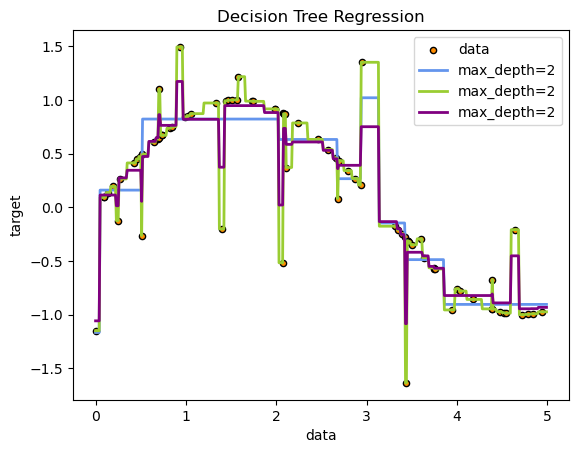

In [11]:
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

gbrt2 = GradientBoostingRegressor(max_depth=2, n_estimators=400, learning_rate=1)
gbrt2.fit(X, y)

gbrt3 = GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate=0.1)
gbrt3.fit(X, y)


y_pred1 = gbrt.predict(X_test)
y_pred2 = gbrt2.predict(X_test)
y_pred3 = gbrt3.predict(X_test)


plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_pred1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_pred2, color="yellowgreen", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_pred3, color="purple", label="max_depth=2", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [12]:
param_grid = [
    {'n_estimators': [1,2,3,4,5,50,100,200], 'max_depth':[1,2,4,6,8,10,12,15,20],'learning_rate':[1, 0.1, 0.5, 1.5, 0.01, 0.05, 2]}
]

gbrt = GradientBoostingRegressor()

grid_search = GridSearchCV(gbrt, param_grid, cv=10,
                           return_train_score=True)
grid_search.fit(X, y)

GridSearchCV(cv=10, estimator=GradientBoostingRegressor(),
             param_grid=[{'learning_rate': [1, 0.1, 0.5, 1.5, 0.01, 0.05, 2],
                          'max_depth': [1, 2, 4, 6, 8, 10, 12, 15, 20],
                          'n_estimators': [1, 2, 3, 4, 5, 50, 100, 200]}],
             return_train_score=True)

In [13]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50}

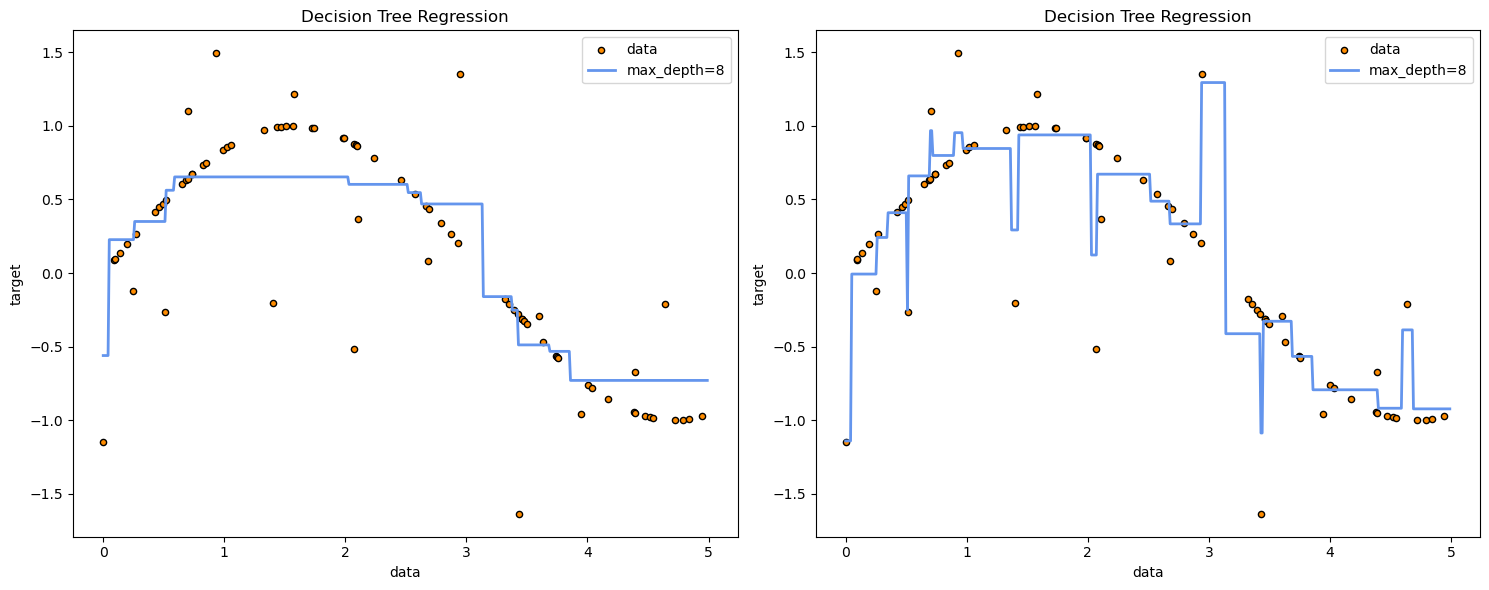

In [14]:
gbrt = GradientBoostingRegressor(max_depth=1, n_estimators=50, learning_rate=0.1)
gbrt.fit(X, y)

y_pred1 = gbrt.predict(X_test)


gbrt2 = GradientBoostingRegressor(max_depth=1, n_estimators=50, learning_rate=1.5)
gbrt2.fit(X, y)

y_pred2 = gbrt2.predict(X_test)

fig, ax = plt.subplots(1,2,figsize=(15,6))

ax[0].scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
ax[0].plot(X_test, y_pred1, color="cornflowerblue", label="max_depth=8", linewidth=2)
ax[0].set_xlabel("data")
ax[0].set_ylabel("target")
ax[0].set_title("Decision Tree Regression")
ax[0].legend()


ax[1].scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
ax[1].plot(X_test, y_pred2, color="cornflowerblue", label="max_depth=8", linewidth=2)
ax[1].set_xlabel("data")
ax[1].set_ylabel("target")
ax[1].set_title("Decision Tree Regression")
ax[1].legend()

plt.tight_layout()
plt.show()

In [15]:
y_pred = cross_val_predict(gbrt, X, y, cv=10)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error (MSE): 0.19
Mean Absolute Error (MAE): 0.33
R^2 Score: 0.66
